<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Load-and-Tidy-Data" data-toc-modified-id="Load-and-Tidy-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Load and Tidy Data</a></span></li><li><span><a href="#MULTIVARIATE-PREDICTION-(WITH-LOOKBACK-AND-TIMESTEPS)" data-toc-modified-id="MULTIVARIATE-PREDICTION-(WITH-LOOKBACK-AND-TIMESTEPS)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)</a></span></li><li><span><a href="#Building-the-Model" data-toc-modified-id="Building-the-Model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Building the Model</a></span></li><li><span><a href="#Set-ESN-constraints" data-toc-modified-id="Set-ESN-constraints-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Set ESN constraints</a></span></li><li><span><a href="#Loss-Functions" data-toc-modified-id="Loss-Functions-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Loss Functions</a></span></li><li><span><a href="#Save-model-while-training" data-toc-modified-id="Save-model-while-training-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Save model while training</a></span></li><li><span><a href="#Fitting-the-model" data-toc-modified-id="Fitting-the-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Fitting the model</a></span></li><li><span><a href="#Plot-prediction-and-actual-for-comparison" data-toc-modified-id="Plot-prediction-and-actual-for-comparison-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Plot prediction and actual for comparison</a></span></li><li><span><a href="#RMSE-for-scaled-predictions" data-toc-modified-id="RMSE-for-scaled-predictions-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>RMSE for scaled predictions</a></span></li><li><span><a href="#RMSE-for-unscaled-predictions" data-toc-modified-id="RMSE-for-unscaled-predictions-11"><span class="toc-item-num">11&nbsp;&nbsp;</span>RMSE for unscaled predictions</a></span></li><li><span><a href="#Plot-prediction-and-historical-data-together" data-toc-modified-id="Plot-prediction-and-historical-data-together-12"><span class="toc-item-num">12&nbsp;&nbsp;</span>Plot prediction and historical data together</a></span></li></ul></div>

# Imports

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM, SimpleRNN
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
from keras.layers import Dense, LSTM, TimeDistributed
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


# Load and Tidy Data

In [2]:
data = pd.read_csv(filepath_or_buffer="../Data/clean_data.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y2,TCMNOM_Y10,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.05,8.92,18.63,278.21,475.250,1.3820,139.78,0.5942
19870521,8.06,8.87,18.45,280.17,469.100,1.3864,140.45,0.5956
19870522,7.97,8.78,18.55,282.16,466.500,1.3883,140.60,0.5977
19870526,7.79,8.55,18.63,289.11,449.000,1.4029,143.30,0.6120
19870527,7.84,8.60,18.60,288.73,449.500,1.3988,143.52,0.6200


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7931 non-null object
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null object
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(6), object(2)
memory usage: 557.6+ KB


In [5]:
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y2           7931 non-null float64
TCMNOM_Y10          7931 non-null float64
DCOILBRENTEU        7858 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7734 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [6]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

# MULTIVARIATE PREDICTION (WITH LOOKBACK AND TIMESTEPS)

In [7]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [8]:
data.columns

Index(['TCMNOM_Y2', 'TCMNOM_Y10', 'DCOILBRENTEU', 'spindx', 'GOLDPMGBD228NLBM',
       'exalus', 'exjpus', 'exukus'],
      dtype='object')

In [9]:
number_of_variables = 8
values = data[['spindx'] + ['TCMNOM_Y2'] + ['TCMNOM_Y10'] + ['DCOILBRENTEU'] + ['GOLDPMGBD228NLBM'] + ['exalus'] + ['exjpus'] + ['exukus']].values
values = values.astype('float32')

In [10]:
look_back = 10
time_steps = 10
series_to_supervised(values, look_back, time_steps)
reframed = series_to_supervised(values, look_back, time_steps)
reframed.tail()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var6(t-10),var7(t-10),var8(t-10),var1(t-9),var2(t-9),...,var7(t+8),var8(t+8),var1(t+9),var2(t+9),var3(t+9),var4(t+9),var5(t+9),var6(t+9),var7(t+9),var8(t+9)
7917,2923.429932,2.82,3.05,85.629997,1204.699951,1.3891,113.660004,0.7702,2925.510010,2.85,...,111.650002,0.7797,2641.250000,2.81,3.08,77.559998,1230.800049,1.4136,112.489998,0.7808
7918,2925.510010,2.85,3.15,85.449997,1201.199951,1.4010,114.190002,0.7696,2901.610107,2.87,...,112.489998,0.7808,2682.629883,2.84,3.12,75.680000,1225.400024,1.4061,112.760002,0.7855
7919,2901.610107,2.87,3.19,86.070000,1203.449951,1.4128,113.790001,0.7684,2885.570068,2.88,...,112.760002,0.7855,2711.739990,2.87,3.15,74.839996,1214.949951,1.4104,112.860001,0.7825
7920,2885.570068,2.88,3.23,85.120003,1203.800049,1.4188,113.559998,0.7633,2884.429932,2.88,...,112.860001,0.7825,2740.370117,2.84,3.14,71.250000,1231.150024,1.3910,112.790001,0.7708
7921,2884.429932,2.88,3.22,84.220001,1186.949951,1.4144,113.345001,0.7622,2880.340088,2.88,...,112.790001,0.7708,2723.060059,2.91,3.22,71.110001,1232.099976,1.3891,113.089996,0.7713


In [11]:
#reshaping prediction value into value range 0 to 1
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(reframed)


/home/abel/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning:

Data with input dtype float32 were all converted to float64 by MinMaxScaler.



In [12]:
# training and testing set
n_train_hours = int(len(scaled) * 0.7)

train = scaled[:n_train_hours, :]
test = scaled[n_train_hours:, :]

In [13]:
# split into input and outputs
train_X, train_y = train[:, :-8 * time_steps], train[:, -8 * time_steps:]
test_X, test_y = test[:, :-8 * time_steps], test[:, -8 * time_steps:]

In [14]:
train_X.shape

(3644, 80)

In [15]:
train_y.shape

(3644, 80)

In [16]:
train_X = train_X.reshape((train_X.shape[0], look_back, number_of_variables))
test_X = test_X.reshape((test_X.shape[0], look_back, number_of_variables))
train_y = train_y.reshape((train_y.shape[0], time_steps, number_of_variables))
test_y = test_y.reshape((test_y.shape[0], time_steps, number_of_variables))

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(3644, 10, 8) (3644, 10, 8) (1563, 10, 8) (1563, 10, 8)


# Building the Model

In [17]:
import random
random.seed(12345)

In [18]:
model = Sequential()
model.add(SimpleRNN(200, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True, 
                    kernel_initializer='orthogonal', bias_initializer='zeros', trainable= False))
model.add(SimpleRNN(100,return_sequences=True))
model.add(SimpleRNN(200,return_sequences=True))
model.add(TimeDistributed(Dense(8, activation = 'linear')))

# Set ESN constraints

In [19]:
alpha = 0.5
w01, w02, w03 = model.layers[0].get_weights()
model.layers[0].set_weights([w01,alpha*w02,w03])



# Loss Functions

In [20]:
import keras.backend as K

# Stanford Paper
def esn_loss(y_true, y_pred):
    loss = K.square(y_true - y_pred)/(K.mean(K.var(y_true)))
    return loss

# DIRECTIONAL AND STD
def dstd(y_true, y_pred):
    s = K.equal(K.sign(y_true[1:] - y_true[:-1]),
                 K.sign(y_pred[1:] - y_pred[:-1]))
    mda = K.mean(K.cast(s, K.floatx()))
    return 0.5*K.std(y_true) + 0.5*mda

def richy(y_true, y_pred):
    var_diff = K.var(y_true) - K.var(y_pred)
    abs_diff_ratio = (y_true/K.abs(y_true)) - (y_pred/K.abs(y_pred))
    return 0.5*var_diff + 0.5*abs_diff_ratio

def clf(y_true, y_pred):
    sigma = K.std(y_true)
    beta = 1/(1 - K.exp(-(1/(2*sigma**2))))
    gaussian = K.exp(-(K.dot(y_true-y_pred, y_true-y_pred)**2)/(2*sigma**2))
    return beta*(1- K.mean(gaussian))



# Linex Loss
def sign_ae(x, y):
    sign_x = K.sign(x)
    sign_y = K.sign(y)
    delta = x - y
    return sign_x * sign_y * K.abs(delta)
    
    
def linex_loss(delta, a=-1, b=1):
    if a!= 0 and b > 0:
        loss = b * (K.exp(a * delta) - a * delta - 1)
        return loss
    else:
        raise ValueError
        
# for growth rate      
def linex_loss_val(y_true, y_pred): 
    delta = sign_ae(y_true, y_pred)
    res = linex_loss(delta)
    return K.mean(res)
    
# for levels  
def linex_loss_ret(y_true, y_pred):
    diff_true = y_true[1:] - y_true[:-1]
    diff_pred = y_pred[1:] - y_pred[:-1]
    
    delta = sign_ae(diff_true, diff_pred)
    res = linex_loss(delta)
    return K.mean(res)

# Save model while training

In [21]:
from keras.callbacks import ModelCheckpoint

weight_path="{}.hdf5".format('ESN_levels')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = False)
callbacks_list = [checkpoint]

In [22]:
model.compile(optimizer='sgd', loss=linex_loss_ret)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10, 200)           41800     
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 10, 100)           30100     
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 10, 200)           60200     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 10, 8)             1608      
Total params: 133,708
Trainable params: 91,908
Non-trainable params: 41,800
_________________________________________________________________


# Fitting the model

In [23]:
n_batch = 256
history = model.fit(train_X, train_y, epochs=50, batch_size=n_batch, validation_data=(test_X, test_y), callbacks = callbacks_list)

Train on 3644 samples, validate on 1563 samples
Epoch 1/50
3644/3644 [==============================] - 1s 311us/step - loss: 0.0117 - val_loss: 5.8000e-05

Epoch 00001: val_loss improved from inf to 0.00006, saving model to ESN_levels.hdf5
Epoch 2/50
3644/3644 [==============================] - 1s 222us/step - loss: 0.0028 - val_loss: 5.4374e-05

Epoch 00002: val_loss improved from 0.00006 to 0.00005, saving model to ESN_levels.hdf5
Epoch 3/50
3644/3644 [==============================] - 1s 190us/step - loss: 0.0016 - val_loss: 5.3115e-05

Epoch 00003: val_loss improved from 0.00005 to 0.00005, saving model to ESN_levels.hdf5
Epoch 4/50
3644/3644 [==============================] - 1s 191us/step - loss: 0.0012 - val_loss: 5.3299e-05

Epoch 00004: val_loss did not improve from 0.00005
Epoch 5/50
3644/3644 [==============================] - 1s 199us/step - loss: 9.7990e-04 - val_loss: 5.3920e-05

Epoch 00005: val_loss did not improve from 0.00005
Epoch 6/50
3644/3644 [===================

3644/3644 [==============================] - 1s 221us/step - loss: 6.0416e-04 - val_loss: 5.7986e-05

Epoch 00050: val_loss did not improve from 0.00005


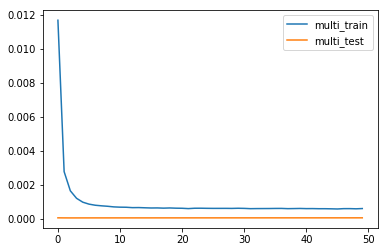

In [24]:
pyplot.plot(history.history['loss'], label='multi_train')
pyplot.plot(history.history['val_loss'], label='multi_test')
pyplot.legend()
pyplot.show()

In [25]:
yhat = model.predict(test_X)

In [26]:
test_y.shape

(1563, 10, 8)

In [27]:
yhat.shape

(1563, 10, 8)

# Plot prediction and actual for comparison

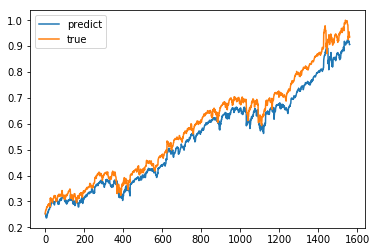

In [28]:
pyplot.plot(yhat[:,0][:,0], label='predict')
pyplot.plot(test_y[:,0][:,0], label='true')
pyplot.legend()
pyplot.show()

In [29]:
test_X.shape

(1563, 10, 8)

In [30]:
test_X.shape

(1563, 10, 8)

In [31]:
yhat.shape

(1563, 10, 8)

In [32]:
# reshape and combine test_X and y_hat (the historical data and the predicted future) 
test_X = yhat.reshape((test_X.shape[0],test_X.shape[1] * test_X.shape[2]))
yhat = yhat.reshape((yhat.shape[0],yhat.shape[1] * yhat.shape[2]))
inv_yhat = concatenate((test_X[:, :], yhat), axis=1)

# undo the scaling on our prediction
inv_yhat = scaler.inverse_transform(inv_yhat)

# extract from inv_yhat our predictions (i.e. 8 variables for time_steps days)
inv_yhat = inv_yhat[:,-8 * time_steps:]


In [33]:
test_y.shape

(1563, 10, 8)

In [34]:
# reshape and combine test_X and test_y (the historical data and the actual future) 
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1] * test_y.shape[2]))
inv_y = concatenate((test_X[:, :], test_y), axis=1)

# undo the scaling on our prediction
inv_y = scaler.inverse_transform(inv_y)

# extract from inv_yhat our predictions (i.e. 8 variables for time_steps days)
inv_y = inv_y[:,-8 * time_steps:]


In [35]:
inv_y

array([[9.05840027e+02, 9.70000029e-01, 3.50000000e+00, ...,
        1.21770000e+00, 9.53199997e+01, 6.06599987e-01],
       [9.32679993e+02, 1.02999997e+00, 3.63000011e+00, ...,
        1.20669997e+00, 9.45999985e+01, 6.06899977e-01],
       [9.40739990e+02, 1.00000000e+00, 3.58999991e+00, ...,
        1.22490001e+00, 9.51299973e+01, 6.10499978e-01],
       ...,
       [2.76878003e+03, 2.86999989e+00, 3.17000008e+00, ...,
        1.41040003e+00, 1.12860001e+02, 7.82500029e-01],
       [2.76778003e+03, 2.92000008e+00, 3.20000005e+00, ...,
        1.39100003e+00, 1.12790001e+02, 7.70799994e-01],
       [2.75587988e+03, 2.92000008e+00, 3.20000005e+00, ...,
        1.38909996e+00, 1.13089996e+02, 7.71300018e-01]])

# RMSE for scaled predictions

In [36]:
rmse = sqrt(mean_squared_error(test_y[:,0], yhat[:,0]))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 0.046


# RMSE for unscaled predictions

In [37]:
rmse = sqrt(mean_squared_error(inv_y[:,0], inv_yhat[:,0]))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 125.307


# Plot prediction and historical data together

In [38]:
predictDates = data.tail(len(inv_y)).index
actual_chart = go.Scatter(x=predictDates, y=inv_y[:,3], name= 'Actual Price')
multi_predict_chart = go.Scatter(x=predictDates, y=inv_yhat[:,3], name= 'Multi Predict Price')
py.iplot([multi_predict_chart, actual_chart])